In [165]:
from matplotlib.image import imread
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image
import eigen

def openImage(imgPath):
    imgOriginal = Image.open(imgPath)
    im = np.array(imgOriginal)
    imgChannels = []
    bands = imgOriginal.getbands()
    imgAlpha = np.nan
    hasAlphaValue = False
    for band in bands:
        if band == 'A':
            imgAlpha = imgOriginal.getchannel("A")
            hasAlphaValue = True
        else:
            imgChannels.append(imgOriginal.getchannel(band))

    return imgChannels, imgAlpha, hasAlphaValue, imgOriginal, bands


def getSVDMatrices(m):
    mat = np.asarray(m).astype(float)
    AxAtranspose = np.dot(mat, mat.T)
    AtransposexA = np.dot(mat.T, mat)

    eigenLeft = eigen.get_eigen_values(AxAtranspose)
    eigenRight = eigen.get_eigen_values(AtransposexA)
    realEigenRight = np.linalg.eig(AtransposexA)[0]
    
    s_sign = np.sign(eigenRight);
    U = np.transpose(eigen.get_eigen_vectors(AxAtranspose, eigenLeft))
    eigenRightUnsigned = np.abs(eigenRight)
    S = np.sqrt(eigenRightUnsigned)
    # S = S[np.argsort(-S)]
    # VT = eigen.get_eigen_vectors(AtransposexA, eigenRight)
    # VT = np.diag(S) @ U.T @ mat
    m, n = mat.shape
    rank = np.linalg.matrix_rank(mat)
    S_mat = np.zeros((rank, rank))
    for i in range(rank) :
        S_mat[i][i] = S[i]

    VT = (np.linalg.inv(S_mat) @ U.T @ mat)

    return U, S_mat, VT

i = 0
def compressSingleChannel(channel, r):
    global i
    u, s, vt = getSVDMatrices(channel)
    U, S, VT = np.linalg.svd(channel)
    #np.savetxt("result.txt" + str(i), s)
    #np.savetxt("real_result.txt" + str(i), S)
    
    compressed = u[:,:r] @ s[0:r, :r] @ vt[:r, :]
    return compressed.astype('uint8')

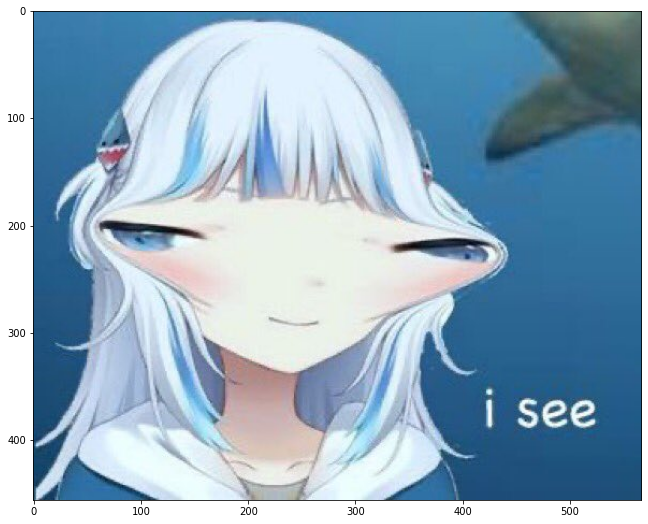

In [166]:
channels, alpha, hasAlpha, original, bands = openImage("guraisee.jpg")
mean = np.mean(original, -1)
plt.figure(figsize=(16, 9))
plt.imshow(original)

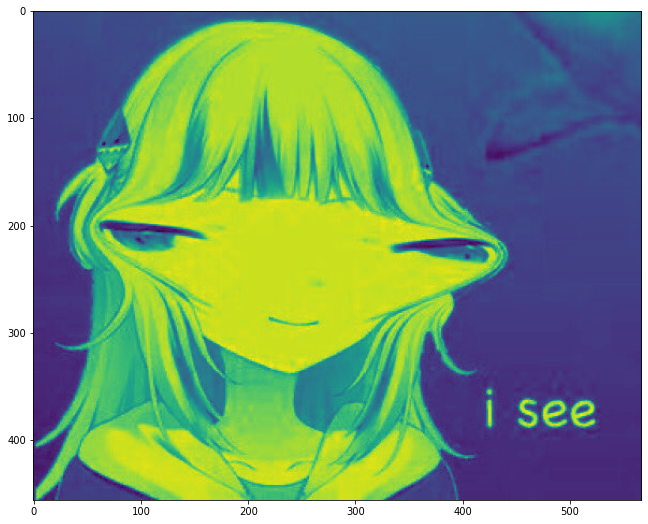

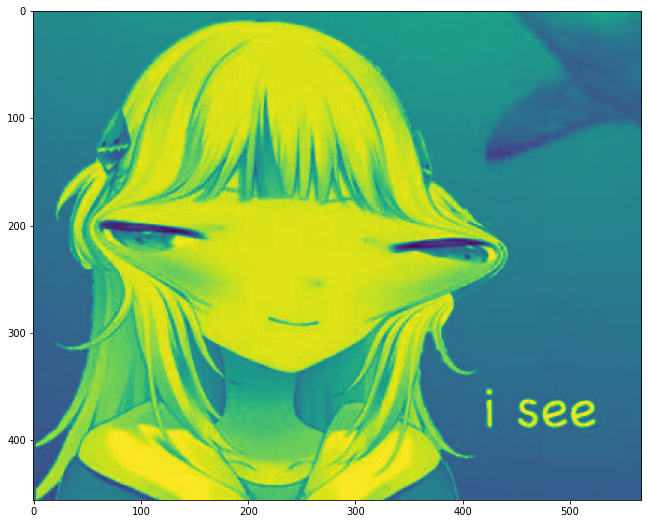

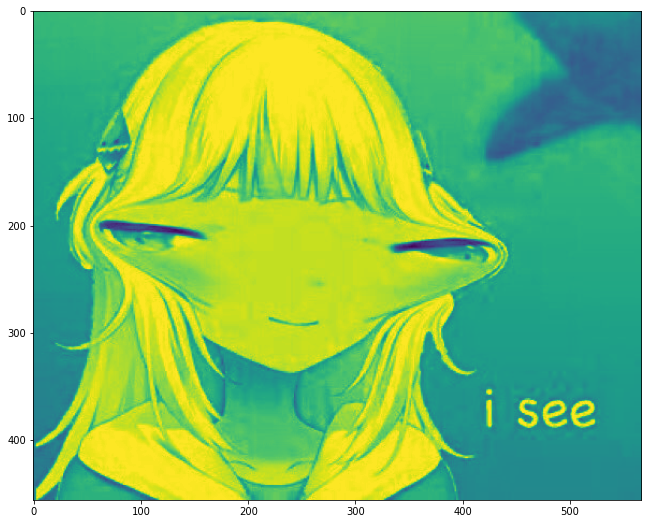

In [167]:
for channel in channels:
    plt.figure(figsize=(16, 9))
    img = plt.imshow(channel)
    plt.show()

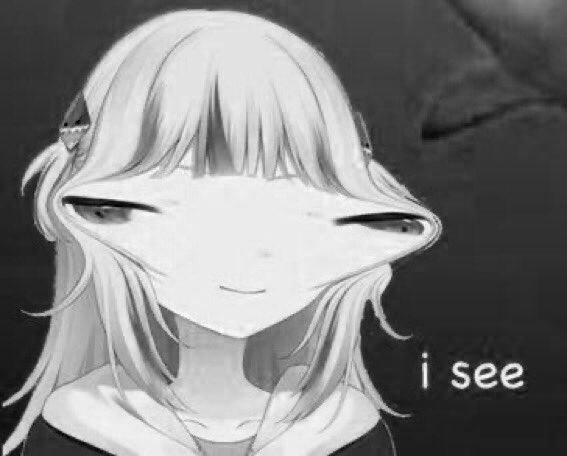

In [168]:
channels[0]

In [169]:
compressSingleChannel(channels[1], 30)

array([[117, 118, 117, ..., 125, 125, 125],
       [117, 118, 118, ..., 125, 125, 125],
       [117, 118, 118, ..., 124, 124, 124],
       ...,
       [ 68,  87, 115, ...,  81,  81,  81],
       [ 67,  82, 104, ...,  80,  80,  80],
       [ 66,  79,  96, ...,  79,  79,  79]], dtype=uint8)

r = 25


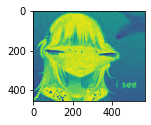

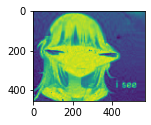

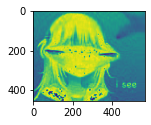

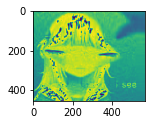

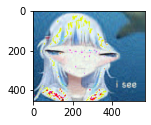

r = 30


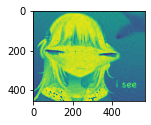

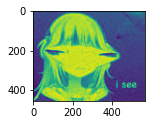

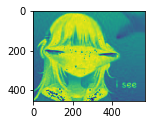

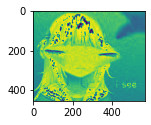

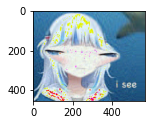

In [170]:
for r in (25, 30):
    print(f"r = {r}")

    compressedMean = compressSingleChannel(mean, r)

    compressedChannels = []
    for channel in channels:
        compressedChannels.append(compressSingleChannel(channel, r))


    compressedImageChannels = []
    for compressedChannel in compressedChannels:
        compressedImageChannels.append(Image.fromarray(compressedChannel, mode=None))

    if hasAlpha:
        compressedImageChannels.append(alpha)

    
    newImage = Image.merge(''.join(bands), tuple(compressedImageChannels))

    plt.figure(figsize=(2, 2))
    img = plt.imshow(compressedMean)
    plt.show()  

    for compressedChannel in compressedChannels:
        plt.figure(figsize=(2, 2))
        img = plt.imshow(compressedChannel)
        plt.show()

    plt.figure(figsize=(2, 2))
    img = plt.imshow(newImage)
    plt.show()